# Setup

In [1]:
using Pkg
Pkg.add("PyCall")
Pkg.add("Conda")

   Resolving package versions...
  No Changes to `~/Documents/9.66/gen-quickstart-master/Project.toml`
  No Changes to `~/Documents/9.66/gen-quickstart-master/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/9.66/gen-quickstart-master/Project.toml`
  No Changes to `~/Documents/9.66/gen-quickstart-master/Manifest.toml`


In [2]:
using PyCall
using Conda
Conda.add("pytorch", channel="pytorch")

[ Info: Running `conda install -y -c pytorch pytorch` in root environment


Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0




In [3]:
using Gen, PyCall, GenPyTorch

In [4]:
include("../inverse-planning/geometric_primitives.jl");
include("../inverse-planning/scene.jl");
include("../inverse-planning/viz.jl")
include("../inverse-planning/planning.jl");

##Creating scene
scene = Scene(xmin=0, xmax=1, ymin=0, ymax=1)
add_obstacle!(scene, make_square(Point(0.30, 0.20), 0.1))
add_obstacle!(scene, make_square(Point(0.83, 0.80), 0.1))
add_obstacle!(scene, make_square(Point(0.80, 0.40), 0.1))
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.20, 0.40), 0.40, wall_thickness));


#Setting params
start = Point(0.1, 0.1)
dt = 0.1
num_ticks = 10
planner_params = PlannerParams(rrt_iters=600, rrt_dt=0.05,
                               refine_iters=3500, refine_std=1.);


#Defining agent model
@gen function agent_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    dest_x ~ uniform(0, 1)
    dest_y ~ uniform(0, 1)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.01
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;


#fixed measurements we will use
measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

In [5]:
torch = pyimport("torch")
nn = torch.nn
F = nn.functional

PyObject <module 'torch.nn.functional' from '/Users/zacharymarinov/.julia/conda/3/aarch64/lib/python3.10/site-packages/torch/nn/functional.py'>

In [6]:
#create a neural with three layers with two hidden layers of 50 units to use for the proposal
#pydef annotation lets us define a Python class
@pydef mutable struct NeuralProposal <: nn.Module
    function __init__(self, num_in)
        # Note the use of pybuiltin(:super): built in Python functions
        # like `super` or `str` or `slice` are all accessed using
        # `pybuiltin`.
        pybuiltin(:super)(NeuralProposal, self).__init__()
        self.fc1 = nn.Linear(num_in, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 5)
    end

    function forward(self, x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    end
end

PyObject <class 'NeuralProposal'>

# Amortized Variational Training

In [7]:
#make neural net a generative function
x_nn = TorchGenerativeFunction(NeuralProposal(4), [TorchArg(true, torch.float)], 1);

In [8]:
softmax(logits) = exp.(logits .- logsumexp(logits))

softmax (generic function with 1 method)

In [9]:
#make neural net a generative function
#distinct params from x_nn + extra input of x_nn
y_nn = TorchGenerativeFunction(NeuralProposal(5), [TorchArg(true, torch.float)], 1);

In [10]:
scale_coord(coord, min, max) = (coord / (max - min)) - 0.5
num_x_bins = 5
num_y_bins = 5;

#amortized variational inference proposal
@gen function custom_dest_proposal_torch(measurements::Vector{Point}, scene::Scene)
    # scale inputs to be in the range [-0.5, 0.5]
    x_first = scale_coord(measurements[1].x, scene.xmin, scene.xmax)
    x_last = scale_coord(measurements[end].x, scene.xmin, scene.xmax)
    y_first = scale_coord(measurements[1].y, scene.ymin, scene.ymax)
    y_last = scale_coord(measurements[end].y, scene.ymin, scene.ymax)
    
    # sample dest_x
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    x_probs ~ x_nn([x_first, y_first, x_last, y_last]) #call with ~ even though not distribution as generative
    dest_x ~ piecewise_uniform(x_bounds, softmax(x_probs))
    
    # sample dest_y
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    y_probs ~ y_nn([x_first, y_first, x_last, y_last, dest_x]) #call with ~ even though not distribution as generative
    
    dest_y ~ piecewise_uniform(y_bounds, softmax(y_probs))
    
    return nothing
end;

In [11]:
#defining weights update
update = Gen.ParamUpdate(Gen.ADAM(0.001, 0.9, 0.999, 1e-8), 
    x_nn => collect(get_params(x_nn)), y_nn => collect(get_params(y_nn)));

In [12]:
#generate (z,x) pairs from the agent model for training
function data_generator()
    
    # since these names are used in the global scope, explicitly declare it
    # local to avoid overwriting the global variable
    local measurements
    local choices
    
    # obtain an execution of the model where planning succeeded
    done = false
    while !done
        (choices, _, retval) = Gen.propose(agent_model, (scene, dt, num_ticks, planner_params))
        (planning_failed, maybe_path) = retval       
        done = !planning_failed
    end

    # construct arguments to the proposal function being trained
    measurements = [Point(choices[:meas => (i, :x)], choices[:meas => (i, :y)]) for i=1:num_ticks]
    inputs = (measurements, scene)
    
    # construct constraints for the proposal function being trained
    constraints = Gen.choicemap()
    constraints[:dest_x] = choices[:dest_x]
    constraints[:dest_y] = choices[:dest_y]
    
    return (inputs, constraints)
end;

In [13]:
#training
Gen.train!(custom_dest_proposal_torch, data_generator, update,
    num_epoch=10, epoch_size=100, num_minibatch=100, minibatch_size=100,
    evaluation_size=10, verbose=true);

epoch 1: generating 100 training examples...
epoch 1: training using 100 minibatches of size 100...
epoch 1: evaluating on 10 examples...
epoch 1: est. objective value: 0.13734708345104976
epoch 2: generating 100 training examples...
epoch 2: training using 100 minibatches of size 100...
epoch 2: evaluating on 10 examples...
epoch 2: est. objective value: -0.18549192638276044
epoch 3: generating 100 training examples...
epoch 3: training using 100 minibatches of size 100...
epoch 3: evaluating on 10 examples...
epoch 3: est. objective value: 0.2329436785221115
epoch 4: generating 100 training examples...
epoch 4: training using 100 minibatches of size 100...
epoch 4: evaluating on 10 examples...
epoch 4: est. objective value: 0.9021987454553365
epoch 5: generating 100 training examples...
epoch 5: training using 100 minibatches of size 100...
epoch 5: evaluating on 10 examples...
epoch 5: est. objective value: 0.3211472898013211
epoch 6: generating 100 training examples...
epoch 6: tra

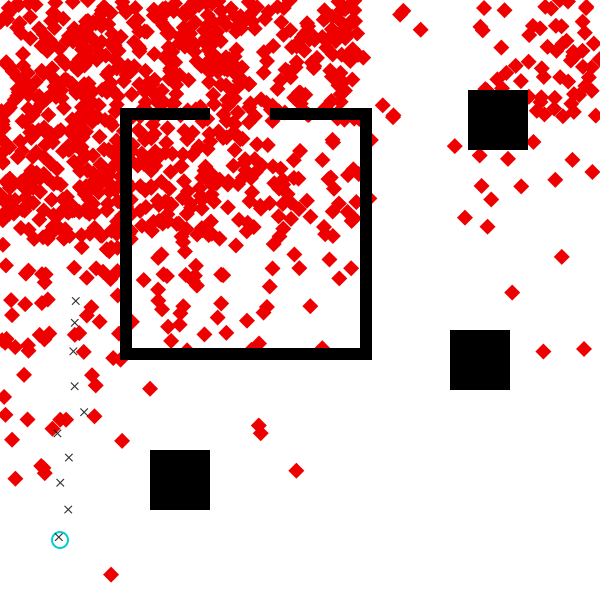

In [14]:
measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

#sampling from trained proposal
function visualize_custom_destination_proposal(measurements, start, dest_proposal; num_samples=1)
    visualize() do 
        for i=1:num_samples
            (proposed_choices, _) = Gen.propose(dest_proposal, (measurements, scene))
            constraints = choicemap(proposed_choices)
            constraints[:start_x] = start.x
            constraints[:start_y] = start.y
            (trace, _) = Gen.generate(agent_model, (scene, dt, num_ticks, planner_params), constraints)
            draw_dest(scene, Point(trace[:dest_x], trace[:dest_y]))
        end
        draw_scene(scene)
        draw_start(scene, start)
        draw_measurements(scene, measurements)
    end
end;
visualize_custom_destination_proposal(measurements, start, custom_dest_proposal_torch, num_samples=1000)

# Pure Variational Training

In [27]:
#creating neural nets to train for proposal
x_nn_var = TorchGenerativeFunction(NeuralProposal(4), [TorchArg(true, torch.float)], 1);
y_nn_var = TorchGenerativeFunction(NeuralProposal(5), [TorchArg(true, torch.float)], 1);

measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

#estimating speed from fixed measurements so can constrain
speed_sum = 0
for i in 1:length(measurements) - 1
    point1 = measurements[i]
    point2 = measurements[i+1]
    distance = sqrt((point1.x - point2.x)^2 + (point1.y - point2.y)^2)
    speed_sum += (distance / dt)
end

speed_estimate = speed_sum / (length(measurements))
    
    

start = measurements[1]

#create observations choicemap
observations = Gen.choicemap()
for (i, point) in enumerate(measurements[1:length(measurements) - 6])
    observations[:meas => (i, :x)] = point.x
    observations[:meas => (i, :y)] = point.y
end

#add extra constraints
observations[:start_x] = start.x
observations[:start_y] = start.y
observations[:speed] = speed_estimate #constraining this really helps

0.4291292692995343

In [28]:
scale_coord(coord, min, max) = (coord / (max - min)) - 0.5
num_x_bins = 5
num_y_bins = 5;

#pure variational inference proposal
#will call NNs with same vals every time
@gen function var_custom_dest_proposal_torch(measurements::Vector{Point}, scene::Scene)
    # scale inputs to be in the range [-0.5, 0.5]
    x_first = scale_coord(measurements[1].x, scene.xmin, scene.xmax)
    x_last = scale_coord(measurements[end].x, scene.xmin, scene.xmax)
    y_first = scale_coord(measurements[1].y, scene.ymin, scene.ymax)
    y_last = scale_coord(measurements[end].y, scene.ymin, scene.ymax)
    
    # sample dest_x
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    x_probs ~ x_nn_var([x_first, y_first, x_last, y_last]) #call with ~ even though not distribution as generative
    dest_x ~ piecewise_uniform(x_bounds, softmax(x_probs))
    
    # sample dest_y
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    y_probs ~ y_nn_var([x_first, y_first, x_last, y_last, dest_x]) #call with ~ even though not distribution as generative
    
    dest_y ~ piecewise_uniform(y_bounds, softmax(y_probs))
    
    return nothing
end

#update method
var_update = Gen.ParamUpdate(Gen.ADAM(0.011, 0.9, 0.999, 1e-8), 
    x_nn_var => collect(get_params(x_nn_var)), y_nn_var => collect(get_params(y_nn_var)));

In [29]:
#training var_custom_dest_proposal
(elbo_estimate, traces, elbo_history) = Gen.black_box_vi!(agent_model, (scene, dt, num_ticks, planner_params), observations, var_custom_dest_proposal_torch, (measurements, scene), var_update, iters=200, verbose=true)

iter 1; est objective: -91.10007716438565
iter 2; est objective: -70.78059372303528
iter 3; est objective: -68.35749991572885
iter 4; est objective: -38.78663885366696
iter 5; est objective: -57.72409445543854
iter 6; est objective: -41.9942283317713
iter 7; est objective: -37.51462855206711
iter 8; est objective: -17.104288932388606
iter 9; est objective: 3.195953528347134
iter 10; est objective: 1.9928337441460475
iter 11; est objective: 12.855140999175303
iter 12; est objective: 13.934988042332028
iter 13; est objective: 22.05054901336096
iter 14; est objective: 23.861870647929425
iter 15; est objective: 22.6856290901817
iter 16; est objective: 23.769225363636508
iter 17; est objective: 23.65417280822999
iter 18; est objective: 23.75744493323168
iter 19; est objective: 23.457801882702913
iter 20; est objective: 23.16232313927253
iter 21; est objective: 23.358749296896203
iter 22; est objective: 23.149920249227186
iter 23; est objective: 23.311390829571746
iter 24; est objective: 23.

iter 193; est objective: 23.171762696548747
iter 194; est objective: 22.720255591754256
iter 195; est objective: 23.00514103828926
iter 196; est objective: 23.823415524926766
iter 197; est objective: 23.81931103574767
iter 198; est objective: 23.81692708666628
iter 199; est objective: 23.75360317115721
iter 200; est objective: 24.08848004489688


(24.08848004489688, Any[Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Point}, Scene], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##var_custom_dest_proposal_torch#300", Bool[0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:y_probs => Gen.ChoiceOrCallRecord{GenPyTorch.TorchFunctionTrace}(GenPyTorch.TorchFunctionTrace(TorchGenerativeFunction(PyObject NeuralProposal(
  (fc1): Linear(in_features=5, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=5, bias=True)
), TorchArg[TorchArg(true, PyObject torch.float32)], 1, PyObject device(type='cpu'), Dict{String, PyObject}("fc3.weight" => PyObject Parameter containing:
tensor([[ 1.0987e-01, -2.9792e-02, -7.0895e-02, -1.2588e-01, -2.9475e-01,
         -3.4433e-01,  4.3449e-02, -1.3140e-01,  1.7022e-02,  1.0900e-01,
         -1.1389e-01, -2.017

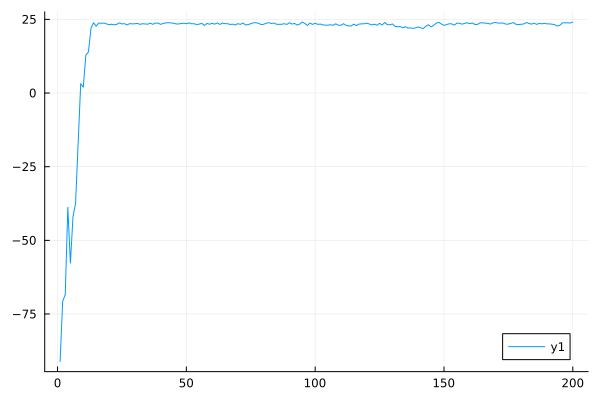

In [30]:
using Plots
#plotting the loss
plot(elbo_history)

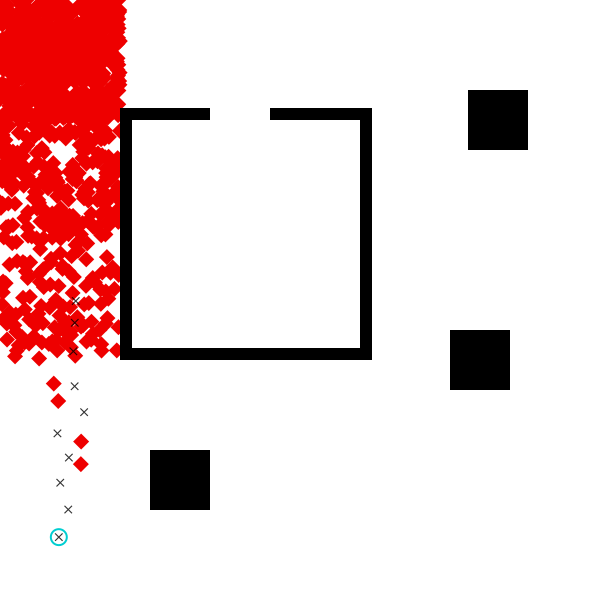

In [31]:
#sampling from the proposal
visualize_custom_destination_proposal(measurements, start,var_custom_dest_proposal_torch, num_samples=1000)

# Computing Log Marginal Likelihood

## Pure Variational Training

In [32]:
num_samples = 10000
sum_log_p = 0

for i in 1:num_samples
    #sample proposal traces and extract choices
    trace = Gen.simulate(var_custom_dest_proposal_torch, (measurements, scene))
    choices = Gen.get_choices(trace) #this is a choicemap
    
    #pass choices into a choicemap to constrain the agent_model to extract density
    trace_constraints = Gen.choicemap()
    trace_constraints[:dest_y] = choices[:dest_y]
    trace_constraints[:dest_x] = choices[:dest_x]
    trace_constraints[:start_x] = measurements[1].x
    trace_constraints[:start_y] = measurements[1].y
    trace_constraints[:speed] = speed_sum / (length(measurements))
    for (i, point) in enumerate(measurements)
        trace_constraints[:meas => (i, :x)] = measurements[i].x
        trace_constraints[:meas => (i, :y)] = measurements[i].y
    end
    
    #calculating densities
    (model_density, ) = Gen.assess(agent_model, (scene, dt, num_ticks, planner_params), trace_constraints)
    proposal_density = Gen.get_score(trace)

    #single sample estimate of log marginal likelihood
    log_p_estim = model_density - proposal_density
    
    sum_log_p += log_p_estim
end

#overall estimate of log marginal likelihood
mean_log_p = sum_log_p / num_samples
print(mean_log_p)



17.347096145928454

## Amortized Variational Training

In [33]:
num_samples = 10000
sum_log_p = 0

for i in 1:num_samples
    #sample proposal traces and extract choices
    trace = Gen.simulate(custom_dest_proposal_torch, (measurements, scene))
    choices = Gen.get_choices(trace) #this is a choicemap

    #pass choices into a choicemap to constrain the agent_model to extract density
    trace_constraints = Gen.choicemap()
    trace_constraints[:dest_y] = choices[:dest_y]
    trace_constraints[:dest_x] = choices[:dest_x]
    trace_constraints[:start_x] = measurements[1].x
    trace_constraints[:start_y] = measurements[1].y
    trace_constraints[:speed] = speed_sum / (length(measurements))
    for (i, point) in enumerate(measurements)
        trace_constraints[:meas => (i, :x)] = measurements[i].x
        trace_constraints[:meas => (i, :y)] = measurements[i].y
    end

    #calculating densities
    (model_density, ) = Gen.assess(agent_model, (scene, dt, num_ticks, planner_params), trace_constraints)
    proposal_density = Gen.get_score(trace)

    #single sample estimate of log marginal likelihood
    log_p_estim = model_density - proposal_density
    
    sum_log_p += log_p_estim
end

#overall estimate of log marginal likelihood
mean_log_p = sum_log_p / num_samples
print(mean_log_p)

-521.8962180909638